In [34]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [35]:
import torch
import torch.nn as nn

class Dehazer(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(Dehazer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

#         self.decoder = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#         )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [36]:
import torch
from torch import nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


In [37]:
class OHaze(Dataset):
    def __init__(self, data_dir, transform=None):
        
        self.data_dir = data_dir
        self.transform = transform[0]
        self.target_transform = transform[1]
        self.x = []
        self.y = []
        
        files = []
        for f in os.listdir(data_dir):
            files.append(f)
        
        for f in files:
            if not f.startswith("_groundtruth_"):
                sample = os.path.join(data_dir, f)
                gt = os.path.join(data_dir, f"_groundtruth_(1)_{f}").replace("_original", "")
                if os.path.split(sample)[1]==".ipynb_checkpoints": continue
                assert os.path.isfile(sample), sample
                assert os.path.isfile(gt), gt
                
                self.x.append(sample)
                self.y.append(gt)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.x[idx]))/255
        target = np.array(Image.open(self.y[idx]))/255
        
        if self.transform is not None:
            image = self.transform(image.astype("float32"))
        if self.target_transform is not None:
            target = self.target_transform(target.astype("float32"))
        
        return image, target

class OHazeTest(Dataset):
    def __init__(self, data_dir, transform):
        
        self.data_dir = data_dir
        self.transform = transform[0]
        self.target_transform = transform[1]
        self.x = []
        self.y = []

        for f in sorted(os.listdir(os.path.join(data_dir, "hazy"))):
            sample = os.path.join(data_dir, "hazy", f)
            assert os.path.isfile(sample), sample
            self.x.append(sample)
        
        for f in sorted(os.listdir(os.path.join(data_dir, "tmap"))):
            sample = os.path.join(data_dir, "tmap", f)
            assert os.path.isfile(sample), sample
            self.y.append(sample)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.x[idx]))/255
        target = np.array(Image.open(self.y[idx]))/255
        
        if self.transform is not None:
            image = self.transform(image.astype("float32"))
        
        if self.target_transform is not None:
            target = self.target_transform(target.astype("float32"))
        
        return image, target    

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(400),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])          
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(400),
])

train_dataset = OHaze("ohaze/train/hazy/output", transform=[transform, target_transform])
test_dataset = OHazeTest("ohaze/test", transform=[transform, target_transform])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=4,  shuffle=False)

print(f"Number of batches per epoch in train set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

Number of batches per epoch in train set: 35
Number of batches in test set: 3


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
model = Dehazer()
#model = UNet(n_class=1)
model.to(device)
num_params_m = sum(torch.numel(p) for p in model.parameters())
print(f"Number of parameters in the model: {num_params_m}")
criterion = nn.MSELoss()

Number of parameters in the model: 3472899


In [41]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
num_epochs = 30

num_batches = len(train_loader)
for epoch in range(num_epochs):
        running_loss = 0.0
        for idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")


Epoch [1/30], Loss: 0.051935
Epoch [2/30], Loss: 0.035882
Epoch [3/30], Loss: 0.030716
Epoch [4/30], Loss: 0.027114
Epoch [5/30], Loss: 0.029474
Epoch [6/30], Loss: 0.028492
Epoch [7/30], Loss: 0.025590
Epoch [8/30], Loss: 0.026752
Epoch [9/30], Loss: 0.024349
Epoch [10/30], Loss: 0.022944
Epoch [11/30], Loss: 0.023734
Epoch [12/30], Loss: 0.018935
Epoch [13/30], Loss: 0.019847
Epoch [14/30], Loss: 0.019218
Epoch [15/30], Loss: 0.020487
Epoch [16/30], Loss: 0.021049
Epoch [17/30], Loss: 0.020385
Epoch [18/30], Loss: 0.017037
Epoch [19/30], Loss: 0.020396
Epoch [20/30], Loss: 0.017796
Epoch [21/30], Loss: 0.021979
Epoch [22/30], Loss: 0.019309
Epoch [23/30], Loss: 0.016458
Epoch [24/30], Loss: 0.015608
Epoch [25/30], Loss: 0.017668
Epoch [26/30], Loss: 0.017156
Epoch [27/30], Loss: 0.014802
Epoch [28/30], Loss: 0.018077
Epoch [29/30], Loss: 0.015331
Epoch [30/30], Loss: 0.013237


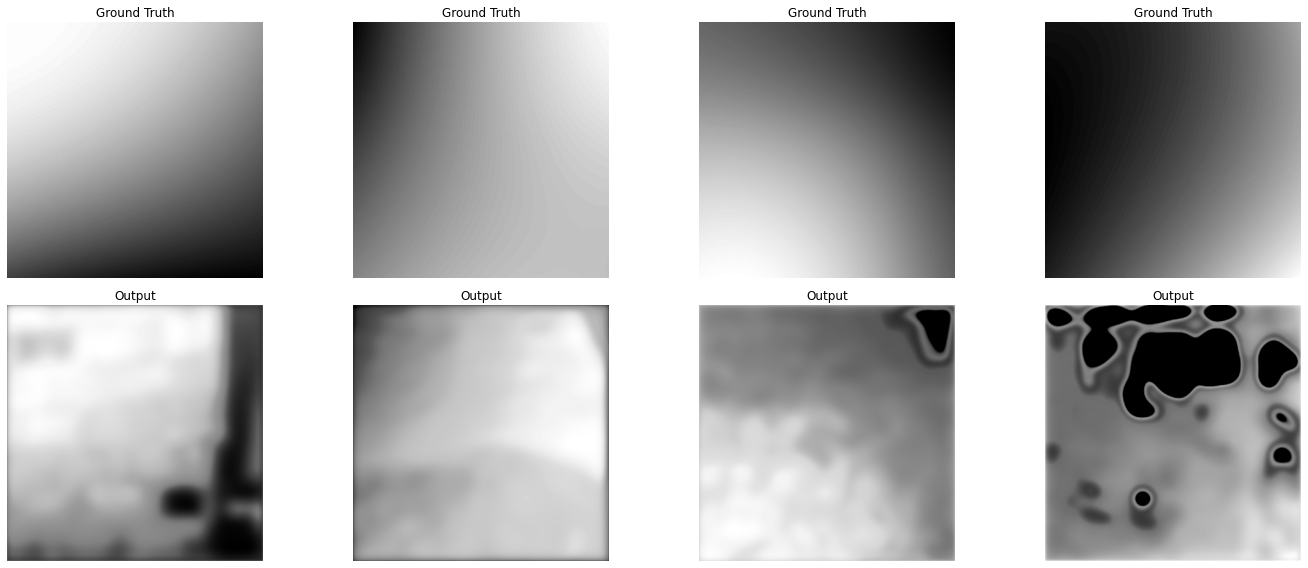

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Convert the outputs and targets to numpy arrays
        outputs_np = outputs.cpu().numpy()
        targets_np = targets.numpy()
 
        fig, axs = plt.subplots(2, batch_size, figsize=(20, 8))
        
        for i in range(batch_size):
            axs[0, i].imshow(targets_np[i].transpose(1, 2, 0), cmap='gray')
            axs[0, i].set_title("Ground Truth")
            axs[0, i].axis("off")

            # Plot predicted image in the second row
            axs[1, i].imshow(outputs_np[i].transpose(1, 2, 0), cmap='gray')
            axs[1, i].set_title("Output")
            axs[1, i].axis("off")
            

        plt.tight_layout()
        plt.show()
        break
        
        
